## Dreaddit: A Reddit Dataset for Stress Analysis in Social Media by Elsbeth Turcan, Kathleen McKeown - Deep models

Sofia Budman     314059155  
Ilana feldman    304257553

In [ ]:
! git clone https://github.com/elana1fel/Dreaddit_implementation.git

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.chdir("/content/Dreaddit_implementation")

retval = os.getcwd()
retval


'/content/gdrive/MyDrive/AML_FINAL'

In [ ]:
import pandas as pd
import numpy as np

train = pd.read_csv("dreaddit-train.csv")
test = pd.read_csv("dreaddit-test.csv")


## **Deep Learning Sequential Model - Bidirectional GRUs with Attention**

**Install Dependencies**

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    # doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
train_reviews = train['text'].values
test_reviews = test['text'].values



**Basic Data Pre-processing**

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 715/715 [00:00<00:00, 5476.81it/s]

CPU times: user 640 ms, sys: 10.5 ms, total: 651 ms
Wall time: 658 ms


**Data Preprocessing and formatting**
To prepare text data for our deep learning model, we transform each review into a sequence. Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the Tokenizer

In [ ]:
import keras

t = keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('jumpsuit', 12164), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=12165
Number of Documents=2838


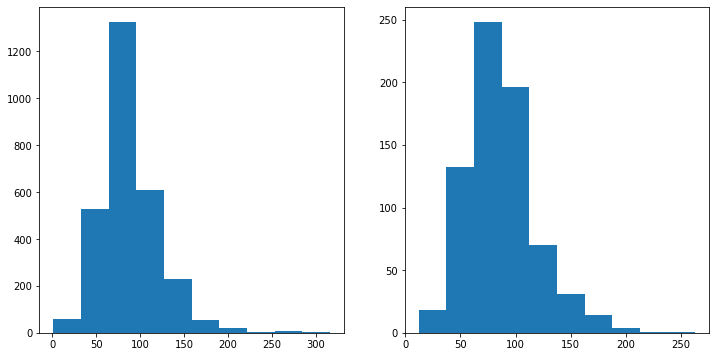

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

**Sequence Normalization**
Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [ ]:
MAX_SEQUENCE_LENGTH = 3000

In [ ]:
# pad dataset to a maximum review length in words
X_train = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((2838, 3000), (715, 3000))

In [ ]:
X_train
df_X_train=pd.DataFrame(X_train)

In [ ]:
X1_train = train.drop(['post_id', 'sentence_range', 'id','subreddit','text','label'], axis = 1)
X1_train

df_X_train
X_train = pd.concat([df_X_train, X1_train], axis=1)
X_train=X_train.to_numpy()
X_train.shape

(2838, 3111)

In [ ]:
X1_test = test.drop(['post_id', 'sentence_range', 'id','subreddit','text','label'], axis = 1)
# X1_train
df_X_test=pd.DataFrame(X_test)

X_test = pd.concat([df_X_test, X1_test], axis=1)
X_test=X_test.to_numpy()
X_test.shape

(715, 3111)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=2 # stress -> 1, nostress -> 0

In [ ]:
train_sentiments=train['label'].values
test_sentiments=test['label'].values
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)
VOCAB_SIZE

12165

**Attention Layer**

In [ ]:
!pip install tensorflow==2.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86.3 MB 1.6 MB/s 
     |████████████████████████████████| 449 kB 83.2 MB/s 
     |████████████████████████████████| 3.8 MB 69.8 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=7745b6cde0b5c7f895e88ca72e1c446001522ea83d0466a6a852a4c6502ef20f
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.8.0
    Uninstalling tensorboard-1.8.0:
      Successfully uninstalled tensorboard-1.8.0
  Attempting un

In [ ]:
!pip install https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.8.0-py3-none-any.whl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.8.0-py3-none-any.whl (46.5 MB)
  Using cached tensorboard-1.8.0-py3-none-any.whl (3.1 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.0.2
    Uninstalling tensorboard-2.0.2:
      Successfully uninstalled tensorboard-2.0.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.8.0 which is incompatible.


In [ ]:
from tensorflow.keras.layers import Layer
from keras import backend as K


class AttentionLayer(keras.layers.Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight( shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight( shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
EMBEDDING_DIM = 500 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = keras.layers.Input(shape=(3111,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x)
x = AttentionLayer(3111)(x)

x = keras.layers.Dense(GRU_DIM*2, activation='tanh')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='tanh')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)

# make the model parallel
# model = multi_gpu_model(model, gpus=2)
    
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3111)]            0         
                                                                 
 embedding (Embedding)       (None, 3111, 500)         6082500   
                                                                 
 bidirectional (Bidirectiona  (None, 3111, 256)        483840    
 l)                                                              
                                                                 
 attention_layer (AttentionL  (None, 256)              3367      
 ayer)                                                           
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [ ]:
X_train

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.25357257e+00, -2.74170300e-03,  6.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         8.82831579e+00,  2.92857143e-01,  2.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         7.84166667e+00,  1.18939390e-02,  6.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.95152372e+00,  4.54545450e-02,  1.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.03676471e+00,  1.59722222e-01,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.41200000e+00,  1.66666670e-02,  6.00000000e+00]])

In [ ]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

In [ ]:
batch_size = 128
model.fit(X_train, y_train, epochs=20, batch_size=batch_size, 
          shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/20
18/18 [==============================] - 19s 594ms/step - loss: 0.6970 - accuracy: 0.4912 - val_loss: 0.6892 - val_accuracy: 0.5458
Epoch 2/20
18/18 [==============================] - 8s 463ms/step - loss: 0.6936 - accuracy: 0.5066 - val_loss: 0.6890 - val_accuracy: 0.5458
Epoch 3/20
18/18 [==============================] - 8s 467ms/step - loss: 0.6950 - accuracy: 0.5079 - val_loss: 0.6909 - val_accuracy: 0.5458
Epoch 4/20
18/18 [==============================] - 8s 454ms/step - loss: 0.6936 - accuracy: 0.5185 - val_loss: 0.6909 - val_accuracy: 0.5458
Epoch 5/20
18/18 [==============================] - 8s 464ms/step - loss: 0.6946 - accuracy: 0.5110 - val_loss: 0.6977 - val_accuracy: 0.4542
Epoch 6/20
18/18 [==============================] - 8s 461ms/step - loss: 0.6933 - accuracy: 0.5101 - val_loss: 0.6921 - val_accuracy: 0.5458
Epoch 7/20
18/18 [==============================] - 8s 465ms/step - loss: 0.6943 - accuracy: 0.5009 - val_loss: 0.6892 - val_accuracy: 0.5458
Epoch

In [ ]:
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

23/23 [==============================] - 4s 119ms/step


[0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['nostress', 'stress']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.66      0.81      0.73       346
           1       0.77      0.62      0.69       369

    accuracy                           0.71       715
   macro avg       0.72      0.71      0.71       715
weighted avg       0.72      0.71      0.71       715



,nostress,stress
nostress,279,67
stress,141,228


# **Stacked LSTM Model**

In [ ]:
EMBEDDING_DIM = 500 # dimension for dense embeddings for each token
GRU_DIM = 128 # total LSTM units

inp = keras.layers.Input(shape=(3111,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(GRU_DIM*2, return_sequences=True))(x)
x = keras.layers.Bidirectional(keras.layers.CuDNNGRU(GRU_DIM, return_sequences=True))(x)
x = AttentionLayer(3111)(x)
x = keras.layers.Dense(GRU_DIM*2, activation='tanh')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(GRU_DIM, activation='tanh')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(1, activation='sigmoid')(x)
# initialize the model
model2 = keras.models.Model(inputs=inp, outputs=outp)

# make the model parallel
#model = multi_gpu_model(model, gpus=2)
    
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.0005), metrics=['accuracy'])
model2.summary()

NameError: ignored

In [ ]:
batch_size = 128
model2.fit(X_train, y_train, epochs=20, batch_size=batch_size, 
           shuffle=True, validation_split=0.2, verbose=1)

NameError: ignored

In [ ]:
# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

23/23 [==============================] - 7s 274ms/step - loss: 1.6116 - accuracy: 0.7203
Accuracy: 72.03%


In [ ]:
prediction_probs = model2.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

23/23 [==============================] - 7s 270ms/step


[0, 0, 1, 1, 0, 0, 0, 0, 1, 0]

In [ ]:
labels = ['nostress', 'stress']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.70      0.74      0.72       346
           1       0.74      0.70      0.72       369

    accuracy                           0.72       715
   macro avg       0.72      0.72      0.72       715
weighted avg       0.72      0.72      0.72       715



,nostress,stress
nostress,257,89
stress,111,258


# **Deep Learning CNN Model**

In [ ]:
!pip install contractions
!pip install textsearch
# !pip install tqdm
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
EMBED_SIZE = 500
EPOCHS=20
BATCH_SIZE=128

In [ ]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=3111))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='tanh'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='leaky_relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 3111, 500)         6082500   
                                                                 
 conv1d_18 (Conv1D)          (None, 3111, 128)         256128    
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 1555, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 1555, 64)          32832     
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 777, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 777, 32)          

In [ ]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.2,
          epochs=10, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/10
18/18 [==============================] - 5s 232ms/step - loss: 2.9512 - accuracy: 0.4758 - val_loss: 0.7345 - val_accuracy: 0.4542
Epoch 2/10
18/18 [==============================] - 4s 220ms/step - loss: 0.8580 - accuracy: 0.4960 - val_loss: 0.6793 - val_accuracy: 0.5458
Epoch 3/10
18/18 [==============================] - 4s 220ms/step - loss: 0.6661 - accuracy: 0.5621 - val_loss: 0.5778 - val_accuracy: 0.6743
Epoch 4/10
18/18 [==============================] - 4s 220ms/step - loss: 0.3099 - accuracy: 0.8762 - val_loss: 0.4449 - val_accuracy: 0.7852
Epoch 5/10
18/18 [==============================] - 4s 220ms/step - loss: 0.0645 - accuracy: 0.9912 - val_loss: 0.4302 - val_accuracy: 0.7870
Epoch 6/10
18/18 [==============================] - 4s 220ms/step - loss: 0.0133 - accuracy: 0.9987 - val_loss: 0.4395 - val_accuracy: 0.7799
Epoch 7/10
18/18 [==============================] - 4s 220ms/step - loss: 0.0075 - accuracy: 0.9982 - val_loss: 0.4830 - val_accuracy: 0.7711
Epoch 

In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

23/23 [==============================] - 1s 15ms/step - loss: 0.7041 - accuracy: 0.6993
Accuracy: 69.93%


In [ ]:
prediction_probs = model.predict(X_test, verbose=1).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in prediction_probs]
predictions[:10]

23/23 [==============================] - 0s 13ms/step


[0, 1, 1, 1, 1, 0, 0, 1, 1, 0]

In [ ]:
labels = ['nostress', 'stress']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

           0       0.75      0.56      0.64       346
           1       0.67      0.83      0.74       369

    accuracy                           0.70       715
   macro avg       0.71      0.70      0.69       715
weighted avg       0.71      0.70      0.69       715



,nostress,stress
nostress,195,151
stress,64,305
